In [9]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [10]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() 
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() 
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

sample_feature = reduce_mem_usage(pd.read_csv('data_for_tree.csv'))

Memory usage of dataframe is 62099672.00 MB
Memory usage after optimization is: 16520303.00 MB
Decreased by 73.4%


In [11]:
continuous_feature_names = [x for x in sample_feature.columns if x not in ['price','brand','model','brand']]

In [12]:
sample_feature = sample_feature.dropna().replace('-', 0).reset_index(drop=True)
sample_feature['notRepairedDamage'] = sample_feature['notRepairedDamage'].astype(np.float32)
train = sample_feature[continuous_feature_names + ['price']]

train_X = train[continuous_feature_names]
train_y = train['price']

In [13]:
#build a simple Linear Regression model
from sklearn.linear_model import LinearRegression
model = LinearRegression(normalize=True)
model = model.fit(train_X, train_y)

In [16]:
'intercept:'+ str(model.intercept_)


'intercept:-110670.68277075786'

In [17]:
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

[('v_6', 3367064.341641869),
 ('v_8', 700675.5609398916),
 ('v_9', 170630.2772322144),
 ('v_7', 32322.66193202752),
 ('v_12', 20473.670796962964),
 ('v_3', 17868.07954149201),
 ('v_11', 11474.938996740202),
 ('v_13', 11261.764560011892),
 ('v_10', 2683.9200905552707),
 ('gearbox', 881.8225039249025),
 ('fuelType', 363.90425072165164),
 ('bodyType', 189.60271012073065),
 ('city', 44.94975120522174),
 ('power', 28.553901616752594),
 ('brand_price_median', 0.5103728134078995),
 ('brand_price_std', 0.45036347092633167),
 ('brand_amount', 0.14881120395065975),
 ('brand_price_max', 0.0031910186703138377),
 ('SaleID', 5.35598991985751e-05),
 ('seller', 4.227447789162397e-06),
 ('offerType', 1.965701812878251e-06),
 ('train', -1.5418627299368382e-06),
 ('brand_price_sum', -2.1750068681876972e-05),
 ('name', -0.0002980012713042195),
 ('used_time', -0.0025158943328787604),
 ('brand_price_average', -0.40490484510115926),
 ('brand_price_min', -2.2467753486893227),
 ('power_bin', -34.42064411725974

The predicted price is obvious different from true price


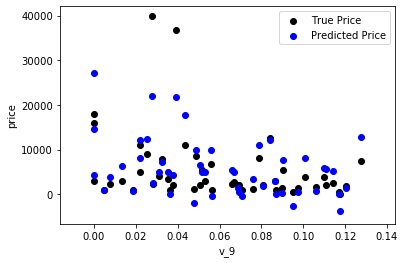

In [18]:
from matplotlib import pyplot as plt
subsample_index = np.random.randint(low=0, high=len(train_y), size=50)
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], model.predict(train_X.loc[subsample_index]), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price is obvious different from true price')
plt.show()

It is clear to see the price shows a typical exponential distribution


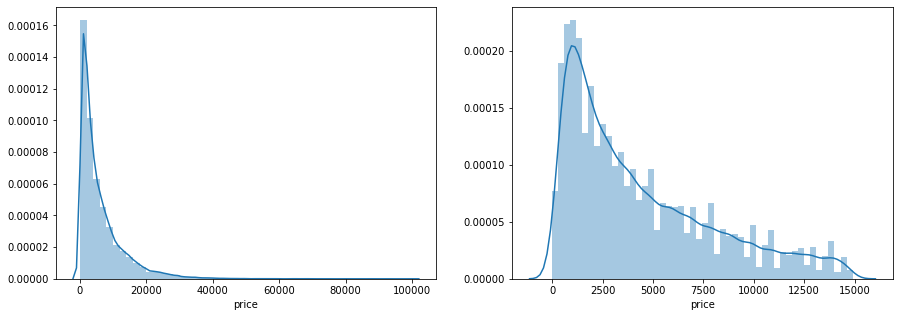

In [19]:
import seaborn as sns
print('It is clear to see the price shows a typical exponential distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y)
plt.subplot(1,2,2)
sns.distplot(train_y[train_y < np.quantile(train_y, 0.9)])

The transformed price seems like normal distribution


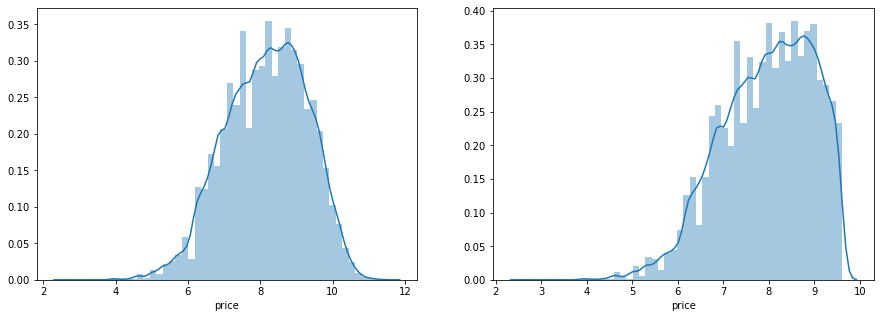

In [20]:
train_y_ln = np.log(train_y + 1)
import seaborn as sns
print('The transformed price seems like normal distribution')
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.distplot(train_y_ln)
plt.subplot(1,2,2)
sns.distplot(train_y_ln[train_y_ln < np.quantile(train_y_ln, 0.9)])

In [21]:
model = model.fit(train_X, train_y_ln)

print('intercept:'+ str(model.intercept_))
sorted(dict(zip(continuous_feature_names, model.coef_)).items(), key=lambda x:x[1], reverse=True)

intercept:18.750749465588196


[('v_9', 8.052409900566975),
 ('v_5', 5.76423659665043),
 ('v_12', 1.6182081236808878),
 ('v_1', 1.4798310582957113),
 ('v_11', 1.1669016563630523),
 ('v_13', 0.9404711296035345),
 ('v_7', 0.7137273083560814),
 ('v_3', 0.6837875771090364),
 ('v_0', 0.008500518010179769),
 ('power_bin', 0.008497969302895196),
 ('gearbox', 0.007922377278325341),
 ('fuelType', 0.00668476970683032),
 ('bodyType', 0.004523520092704702),
 ('power', 0.000716189420535513),
 ('brand_price_min', 3.3343511147504113e-05),
 ('brand_amount', 2.8978797042776285e-06),
 ('brand_price_median', 1.2571172873047128e-06),
 ('brand_price_std', 6.659176363479574e-07),
 ('brand_price_max', 6.194956307516032e-07),
 ('brand_price_average', 5.999345965001714e-07),
 ('SaleID', 2.1194170039653628e-08),
 ('seller', 1.665849680421161e-10),
 ('train', -1.8616219676914625e-11),
 ('offerType', -8.449063670923351e-11),
 ('brand_price_sum', -1.5126504215926567e-10),
 ('name', -7.015512588899606e-08),
 ('used_time', -4.122479372350831e-06)

The predicted price seems normal after np.log transforming


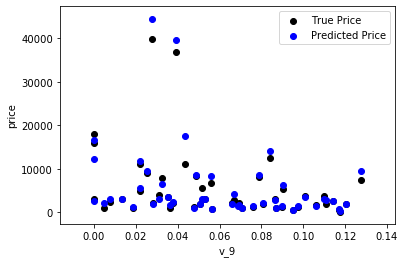

In [22]:
plt.scatter(train_X['v_9'][subsample_index], train_y[subsample_index], color='black')
plt.scatter(train_X['v_9'][subsample_index], np.exp(model.predict(train_X.loc[subsample_index])), color='blue')
plt.xlabel('v_9')
plt.ylabel('price')
plt.legend(['True Price','Predicted Price'],loc='upper right')
print('The predicted price seems normal after np.log transforming')
plt.show()

In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error,  make_scorer

def log_transfer(func):
    def wrapper(y, yhat):
        result = func(np.log(y), np.nan_to_num(np.log(yhat)))
        return result
    return wrapper

scores = cross_val_score(model, X=train_X, y=train_y, verbose=1, cv = 5, scoring=make_scorer(log_transfer(mean_absolute_error)))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [24]:
print('AVG:', np.mean(scores))

AVG: 1.3658023920313922


In [25]:
scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=1, cv = 5, scoring=make_scorer(mean_absolute_error))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished


In [26]:
print('AVG:', np.mean(scores))

AVG: 0.19325301837047437


In [27]:
scores = pd.DataFrame(scores.reshape(1,-1))
scores.columns = ['cv' + str(x) for x in range(1, 6)]
scores.index = ['MAE']
scores

,cv1,cv2,cv3,cv4,cv5
MAE,0.190792,0.193758,0.194132,0.191825,0.195758


In [28]:
import datetime
sample_feature = sample_feature.reset_index(drop=True)
split_point = len(sample_feature) // 5 * 4

train = sample_feature.loc[:split_point].dropna()
val = sample_feature.loc[split_point:].dropna()

train_X = train[continuous_feature_names]
train_y_ln = np.log(train['price'] + 1)
val_X = val[continuous_feature_names]
val_y_ln = np.log(val['price'] + 1)

model = model.fit(train_X, train_y_ln)

mean_absolute_error(val_y_ln, model.predict(val_X))

0.19577667270301002

<module 'matplotlib.pyplot' from 'C:\\Users\\wzzan\\AppData\\Local\\Programs\\Python\\Python37\\lib\\site-packages\\matplotlib\\pyplot.py'>

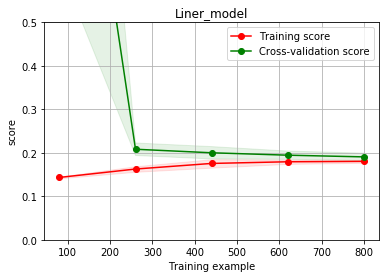

In [30]:
from sklearn.model_selection import learning_curve, validation_curve
? learning_curve
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_size=np.linspace(.1, 1.0, 5 )):  
    plt.figure()  
    plt.title(title)  
    if ylim is not None:  
        plt.ylim(*ylim)  
    plt.xlabel('Training example')  
    plt.ylabel('score')  
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_size, scoring = make_scorer(mean_absolute_error))  
    train_scores_mean = np.mean(train_scores, axis=1)  
    train_scores_std = np.std(train_scores, axis=1)  
    test_scores_mean = np.mean(test_scores, axis=1)  
    test_scores_std = np.std(test_scores, axis=1)  
    plt.grid()#区域  
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,  
                     train_scores_mean + train_scores_std, alpha=0.1,  
                     color="r")  
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,  
                     test_scores_mean + test_scores_std, alpha=0.1,  
                     color="g")  
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r',  
             label="Training score")  
    plt.plot(train_sizes, test_scores_mean,'o-',color="g",  
             label="Cross-validation score")  
    plt.legend(loc="best")  
    return plt  

plot_learning_curve(LinearRegression(), 'Liner_model', train_X[:1000], train_y_ln[:1000], ylim=(0.0, 0.5), cv=5, n_jobs=1) 

In [31]:
train = sample_feature[continuous_feature_names + ['price']].dropna()

train_X = train[continuous_feature_names]
train_y = train['price']
train_y_ln = np.log(train_y + 1)

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

models = [LinearRegression(),
          Ridge(),
          Lasso()]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')
    
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

LinearRegression is finished
Ridge is finished
Lasso is finished


,LinearRegression,Ridge,Lasso
cv1,0.190792,0.194832,0.383899
cv2,0.193758,0.197632,0.381893
cv3,0.194132,0.198123,0.384090
cv4,0.191825,0.195670,0.380526
cv5,0.195758,0.199676,0.383611


intercept:18.750749399255977


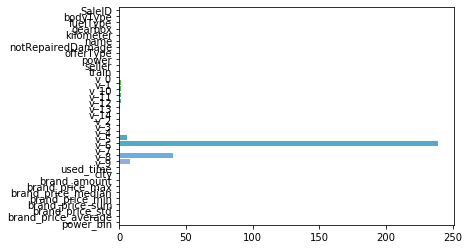

In [33]:
model = LinearRegression().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)

intercept:4.671709787409427


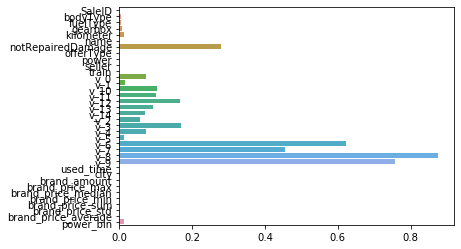

In [34]:
model = Ridge().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)



intercept:8.672182402894254


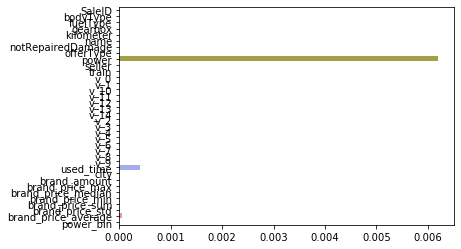

In [35]:
model = Lasso().fit(train_X, train_y_ln)
print('intercept:'+ str(model.intercept_))
sns.barplot(abs(model.coef_), continuous_feature_names)



In [40]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
from lightgbm.sklearn import LGBMRegressor

models = [LinearRegression(),
          DecisionTreeRegressor(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          MLPRegressor(solver='lbfgs', max_iter=100), 
          XGBRegressor(n_estimators = 100, objective='reg:squarederror'), 
          LGBMRegressor(n_estimators = 100)]

result = dict()
for model in models:
    model_name = str(model).split('(')[0]
    scores = cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error))
    result[model_name] = scores
    print(model_name + ' is finished')


LinearRegression is finished
DecisionTreeRegressor is finished
RandomForestRegressor is finished
GradientBoostingRegressor is finished
MLPRegressor is finished
XGBRegressor is finished
LGBMRegressor is finished


In [39]:
!pip3 install lightgbm

In [41]:
result = pd.DataFrame(result)
result.index = ['cv' + str(x) for x in range(1, 6)]
result

,LinearRegression,DecisionTreeRegressor,RandomForestRegressor,GradientBoostingRegressor,MLPRegressor,XGBRegressor,LGBMRegressor
cv1,0.190792,0.198330,0.132908,0.168900,378.429843,0.142333,0.141546
cv2,0.193758,0.193555,0.134354,0.171857,595.411256,0.140987,0.145501
cv3,0.194132,0.189686,0.133516,0.170931,518.868107,0.139266,0.143887
cv4,0.191825,0.189427,0.132625,0.169083,309.074557,0.137399,0.142497
cv5,0.195758,0.205223,0.137249,0.174072,377.177065,0.143998,0.144852


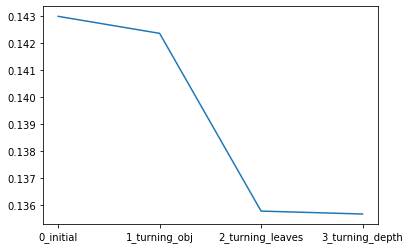

In [43]:
## parameter set of LGB：

objective = ['regression', 'regression_l1', 'mape', 'huber', 'fair']

num_leaves = [3,5,10,15,20,40, 55]
max_depth = [3,5,10,15,20,40, 55]
bagging_fraction = []
feature_fraction = []
drop_rate = []

#greedy tuning
best_obj = dict()
for obj in objective:
    model = LGBMRegressor(objective=obj)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_obj[obj] = score
    
best_leaves = dict()
for leaves in num_leaves:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0], num_leaves=leaves)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_leaves[leaves] = score
    
best_depth = dict()
for depth in max_depth:
    model = LGBMRegressor(objective=min(best_obj.items(), key=lambda x:x[1])[0],
                          num_leaves=min(best_leaves.items(), key=lambda x:x[1])[0],
                          max_depth=depth)
    score = np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))
    best_depth[depth] = score

    
sns.lineplot(x=['0_initial','1_turning_obj','2_turning_leaves','3_turning_depth'], y=[0.143 ,min(best_obj.values()), min(best_leaves.values()), min(best_depth.values())])


In [44]:
#Grid Search Tuning
from sklearn.model_selection import GridSearchCV

parameters = {'objective': objective , 'num_leaves': num_leaves, 'max_depth': max_depth}
model = LGBMRegressor()
clf = GridSearchCV(model, parameters, cv=5)
clf = clf.fit(train_X, train_y)

clf.best_params_


{'max_depth': 15, 'num_leaves': 55, 'objective': 'regression'}

In [45]:
model = LGBMRegressor(objective='regression',
                          num_leaves=55,
                          max_depth=15)

np.mean(cross_val_score(model, X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)))

0.13754820909576437

In [47]:
from bayes_opt import BayesianOptimization
def rf_cv(num_leaves, max_depth, subsample, min_child_samples):
    val = cross_val_score(
        LGBMRegressor(objective = 'regression_l1',
            num_leaves=int(num_leaves),
            max_depth=int(max_depth),
            subsample = subsample,
            min_child_samples = int(min_child_samples)
        ),
        X=train_X, y=train_y_ln, verbose=0, cv = 5, scoring=make_scorer(mean_absolute_error)
    ).mean()
    return 1 - val

rf_bo = BayesianOptimization(
    rf_cv,
    {
    'num_leaves': (2, 100),
    'max_depth': (2, 100),
    'subsample': (0.1, 1),
    'min_child_samples' : (2, 100)
    }
)
rf_bo.maximize()

|   iter    |  target   | max_depth | min_ch... | num_le... | subsample |
-------------------------------------------------------------------------
|  1        |  0.8064   |  2.798    |  48.79    |  18.73    |  0.9748   |
|  2        |  0.8666   |  80.36    |  8.782    |  71.96    |  0.7968   |
|  3        |  0.8273   |  82.9     |  80.31    |  6.514    |  0.1454   |
|  4        |  0.8659   |  49.9     |  89.7     |  66.89    |  0.7929   |
|  5        |  0.8654   |  92.06    |  62.06    |  61.53    |  0.9933   |
|  6        |  0.8691   |  99.45    |  99.16    |  96.77    |  0.3176   |
|  7        |  0.826    |  3.402    |  25.89    |  99.42    |  0.3096   |
|  8        |  0.8692   |  99.47    |  4.36     |  97.3     |  0.5132   |
|  9        |  0.8585   |  6.979    |  98.47    |  97.39    |  0.3732   |
|  10       |  0.8694   |  71.43    |  72.75    |  99.65    |  0.442    |
|  11       |  0.8691   |  61.05    |  99.36    |  97.35    |  0.8987   |
|  12       |  0.8689   |  69.14    | 

In [48]:
1 - rf_bo.max['target']

0.13057999524962827